# Team-reasoning in the Prisoners-Dilemma
This notebook implements a simulation of the PD game using mesa. In the simulation, agents, which are either team-reasoners or not, are randomly assigned other players, with whom they play the PD. The players collected utilities are saved and displayed at the end of the run.

In [44]:
# !pip install nashpy==0.0.20

# game-theoretic:
import nashpy as nash

# mesa:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# standards:
import numpy as np
import pandas as pd
import tqdm

# graphics:
import seaborn as sns
import matplotlib.pyplot as plt

# code formatting:
%load_ext nb_black


# 3d graphic team -reasoners

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [6]:
A = np.array([[5-3, 5-0], [5-5, 5-1]])
B = np.array([[5-3, 5-5], [5-0, 5-1]])
prisoners_dilemma = nash.Game(A, B)

equilibria = prisoners_dilemma.support_enumeration()
for eq in equilibria: #check equilibria
    print(eq)


(array([1., 0.]), array([1., 0.]))


<IPython.core.display.Javascript object>

In [236]:
def random_argmax(b):  # argmax with tiebreaking.
    return np.random.choice(np.flatnonzero(b == np.max(b)))


class MyAgent(Agent):
    """ """

    def __init__(
        self, unique_id, model, team_reasoner=False, probability_team_reasoning=0.9
    ):
        super().__init__(unique_id, model)

        self.team_reasoner = team_reasoner
        self.alive = True
        self.gathered_utility = 0
        self.probability_team_reasoning = probability_team_reasoning
        self.team_reasoning_counter = 0

    def step(self):
        #         The agent's step will go here.
        other_player = self.random.choice(self.model.schedule.agents)

        #         print(self.model.game)
        choices = [
            self.reason(
                player,
                player.team_reasoner,
                player.model.game,
                player.probability_team_reasoning,
            )
            for player in [self, other_player]
        ]
        payoff = self.model.game[list(choices[0]), list(choices[1])]
        self.gathered_utility += payoff[0]
        pass

    def reason(self, player, team_reasoner, game, probability_team_reasoning):
        if team_reasoner == True:

            if np.random.rand() < probability_team_reasoning:
                choice = random_argmax([0, 1])
                strat = np.zeros(2)
                strat[choice] = 1
                if player == self:
                    self.team_reasoning_counter += 1  # Hic sunt draconis!
                return strat
            else:
                choice = random_argmax([1, 0])
                strat = np.zeros(2)
                strat[choice] = 1
                return strat
        else:
            choice = random_argmax([1, 0])
            strat = np.zeros(2)
            strat[choice] = 1
            return strat


class MyModel(Model):
    """"""

    def __init__(
        self, proportion_team_reasoners, n_agents, game, probability_team_reasoning
    ):
        super().__init__()

        self.num_agents = n_agents
        self.schedule = RandomActivation(self)
        self.game = game

        team_reason_until = int(proportion_team_reasoners * n_agents)
        for ix, i in enumerate(range(self.num_agents)):
            if ix < team_reason_until:
                a = MyAgent(
                    unique_id=i,
                    model=self,
                    team_reasoner=True,
                    probability_team_reasoning=probability_team_reasoning,
                )
            else:
                a = MyAgent(
                    unique_id=i,
                    model=self,
                    team_reasoner=False,
                    probability_team_reasoning=probability_team_reasoning,
                )

            self.schedule.add(a)

        agent_reporters = {
            "team_reasoner": lambda a: getattr(a, "team_reasoner", None),
            "gathered_utility": lambda a: getattr(a, "gathered_utility", None),
            "alive": lambda a: getattr(a, "alive", None),
            "team_reasoning_counter": lambda a: getattr(
                a, "team_reasoning_counter", None
            ),
        }

        model_reporters = {}

        self.datacollector = DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)


model = MyModel(
    proportion_team_reasoners=0.05,
    n_agents=200,
    game=prisoners_dilemma,
    probability_team_reasoning=0.0,
)

for t in tqdm.tqdm_notebook(range(100)):
    model.step()

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:117: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [237]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

<IPython.core.display.Javascript object>

In [238]:
agent_df = agent_df.reset_index()

<IPython.core.display.Javascript object>

In [239]:
agent_df

,Step,AgentID,team_reasoner,gathered_utility,alive,team_reasoning_counter
0,1,0,True,2.0,True,0
1,1,1,True,2.0,True,0
2,1,2,True,2.0,True,0
3,1,3,True,2.0,True,0
4,1,4,True,2.0,True,0
...,...,...,...,...,...,...
19995,100,195,False,200.0,True,0
19996,100,196,False,200.0,True,0
19997,100,197,False,200.0,True,0
19998,100,198,False,200.0,True,0


<IPython.core.display.Javascript object>

Text(0.0, 1.0, 'Collected utility after 100 iterations')

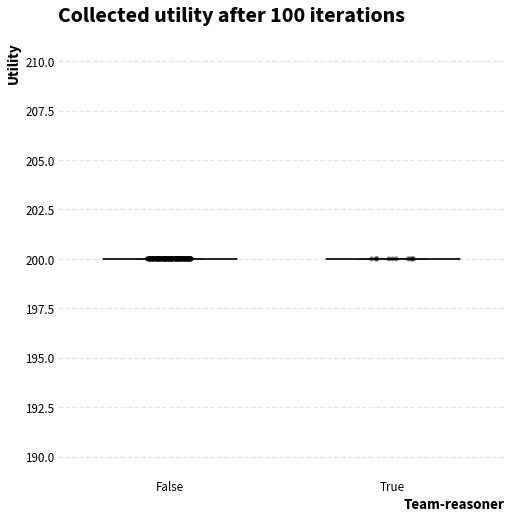

<IPython.core.display.Javascript object>

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
plt.style.use("opinions.mplstyle")

to_plot = agent_df[agent_df["Step"] == np.max(agent_df["Step"])]

# Plot the orbital period with horizontal boxes
sns.boxplot(
    x="team_reasoner",
    y="gathered_utility",
    data=to_plot,
    whis=[0, 100],
    width=0.6,
    palette=["#1a2340", "#f2ad00"],
)

# Add in points to show each observation
sns.stripplot(
    x="team_reasoner",
    y="gathered_utility",
    size=5,
    data=to_plot,
    color="black",
    linewidth=0,
    alpha=0.5,
)

plt.xlabel("Team-reasoner")
plt.ylabel("Utility")
plt.title("Collected utility after " + str(np.max(agent_df["Step"])) + " iterations")

Text(1, 0, 'Utility')

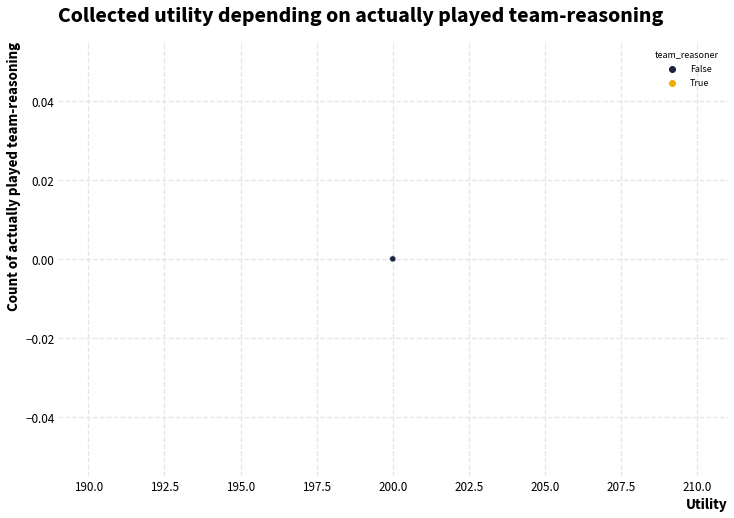

<IPython.core.display.Javascript object>

In [241]:
# to_plot
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use("opinions.mplstyle")

sns.scatterplot(
    x=to_plot["gathered_utility"],
    y=to_plot["team_reasoning_counter"],
    hue=to_plot["team_reasoner"],
    palette=["#1a2340", "#f2ad00"],
)

plt.title("Collected utility depending on actually played team-reasoning")
plt.ylabel("Count of actually played team-reasoning")
plt.xlabel("Utility")

# Varying parameters

In [173]:
collected_results = []
run_no = 0
for proportion_of_team_reasoners in tqdm.tqdm_notebook(np.linspace(0.05, 0.95, 11)):
    for probability_team_reasoning in tqdm.tqdm_notebook(np.linspace(0, 1, 11)):

        model = MyModel(
            proportion_team_reasoners=proportion_of_team_reasoners,
            n_agents=200,
            game=prisoners_dilemma,
            probability_team_reasoning=probability_team_reasoning,
        )

        for t in range(100):
            model.step()
        model_df = model.datacollector.get_model_vars_dataframe()
        agent_df = model.datacollector.get_agent_vars_dataframe()
        agent_df = agent_df.reset_index()

        agent_df["run_no"] = run_no
        agent_df["proportion_team_reasoners"] = proportion_of_team_reasoners
        agent_df["probability_team_reasoning"] = probability_team_reasoning

        collected_results.append(
            agent_df
        )  # this is not memory-friendly in the long run...
        run_no += 1

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [234]:
collected_frame = pd.concat(collected_results)

<IPython.core.display.Javascript object>

In [235]:
grouped = collected_frame.groupby(["run_no", "team_reasoner"])[
    "gathered_utility"
].mean()
grouped = pd.DataFrame(grouped).reset_index()
display(grouped)
grouped = grouped.groupby("run_no")

diff_frames = []
for name, group in grouped:
    
    diff_frame =  pd.DataFrame(collected_frame[collected_frame["run_no"] == name].iloc[0]).T[
            ["run_no", "proportion_team_reasoners", "probability_team_reasoning"]
        ]
    performance_diff = (
        group[group["team_reasoner"] == False]["gathered_utility"].iloc[0]
        - group[group["team_reasoner"] == True]["gathered_utility"].iloc[0]
    )
    diff_frame['performance_diff'] = performance_diff
    diff_frames.append(diff_frame)


,run_no,team_reasoner,gathered_utility
0,0,False,101.000000
1,0,True,101.000000
2,1,False,101.787105
3,1,True,92.580000
4,2,False,102.793368
...,...,...,...
237,118,True,165.688158
238,119,False,229.844000
239,119,True,178.649737
240,120,False,244.571000


<IPython.core.display.Javascript object>

In [176]:
difference_frame = pd.concat(diff_frames)

<IPython.core.display.Javascript object>

In [177]:
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Mean utility: non-TR - TR')

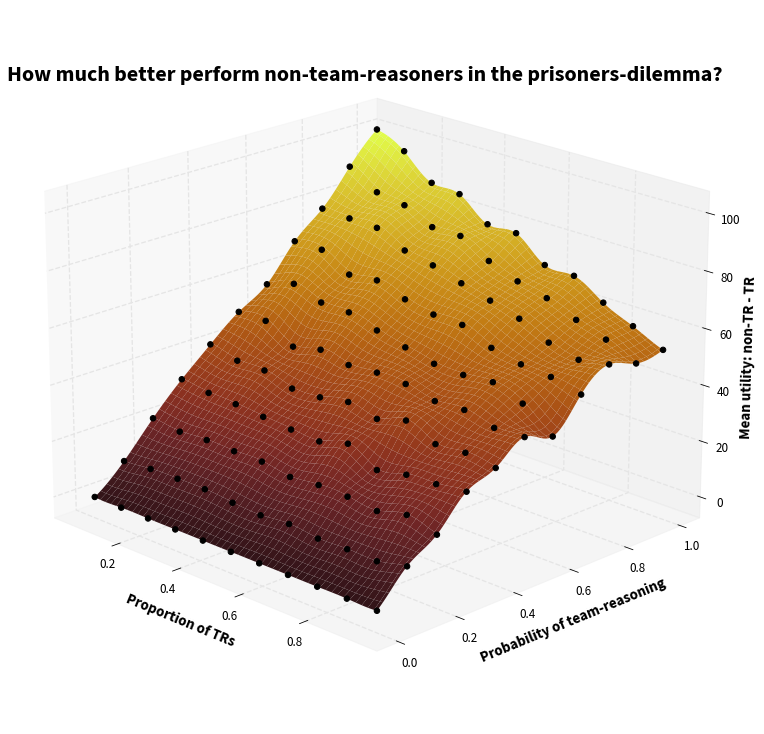

<IPython.core.display.Javascript object>

In [242]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,-45)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],function='multiquadric')#,smooth=1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]), np.max(difference_frame["proportion_team_reasoners"]),100)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]), np.max(difference_frame["probability_team_reasoning"]),100)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)

ax.plot_surface(B1, B2, Z,alpha=1.,cmap=cmocean.cm.solar)
ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],
    s=30,c='black',alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Mean utility: non-TR - TR")
# ax.invert_xaxis()

